In [6]:
#LIMITATIONS:
#    Unable to filter by ratings (no input parameter available)

In [7]:
# Import required dependencies
import json
import tweepy
import time
import csv
import requests
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt

#Import authentication keys
from config import api_key, client_id, consumer_key, access_token, access_token_secret, consumer_secret

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [8]:
#Prepare empty lists to store all data
restaurant_name = []
restaurant_rating = []
restaurant_reviewcount = []
restaurant_city = []
restaurant_state = []
restaurant_zipcode = []
restaurant_price=[]
restaurant_type = []
restaurant_category = []

#Necessary to pass header in each API request.  Do not change this.
headers = {'Authorization': f"Bearer {api_key}"}
base_url = 'https://api.yelp.com/v3/businesses/search?'
base_filters = '&categories=Restaurants&limit=50&is_closed=0'

# Construct the URL to request Yelp API data

url_location = ['San Francisco, CA', 'New York, NY', 'Des Moines, IA', 'Omaha, NE']
url_price = np.arange(1, 5, 1)
url_offset = np.arange(0, 850, 50)

In [9]:
#Yelp provides us with a list of 50 results per query

#loop through different page sets (e.g. 0-50, 51-100, 101-150...)
for off in url_offset:

    #loop through list of rural and suburb locations
    for location in url_location:

        #loop through list of prices $-$$$$
        for price in url_price:

            #prepare query URL for each price range and each zip code region
            query_url = f'{base_url}&location={location}&price={price}{base_filters}&offset={off}'

            #extract data into a response variable
            response = requests.get(query_url, headers=headers).json()

            restaurant_list = response['businesses']

            #loop through responses and append data to empty lists
            for restaurant in restaurant_list:
                restaurant_name.append(restaurant["name"])
                restaurant_rating.append(restaurant["rating"])
                restaurant_reviewcount.append(restaurant["review_count"])
                restaurant_price.append(len(restaurant["price"]))
                restaurant_city.append(restaurant["location"]["city"])
                restaurant_state.append(restaurant["location"]["state"])
                restaurant_zipcode.append(restaurant["location"]["zip_code"])
                restaurant_type.append(restaurant["categories"][0]["title"])

            #prepare dataframe from dictionary
            restaurant_df = pd.DataFrame({'Restaurant':restaurant_name, 
                               'Rating':restaurant_rating, 
                               'Reviews': restaurant_reviewcount, 
                               'Price':restaurant_price, 
                               'City': restaurant_city,
                               'State': restaurant_state,
                               'ZipCode':restaurant_zipcode,
                               #need to be able to derive multiple categories
                               'Category':restaurant_type})

In [10]:
#drop duplicate records by restaurant and city
restaurant_df.dropna(how='any')
restaurant_df.count()

Restaurant    7283
Rating        7283
Reviews       7283
Price         7283
City          7283
State         7283
ZipCode       7283
Category      7283
dtype: int64

In [13]:
#investigate data by outputting results to CSV file
restaurant_df.to_csv("Restaurant_Info.csv", index=False, encoding='utf-8')

In [14]:
#START FROM HERE TO PREVENT LOADING A LOT OF DATA
#-------------------------------------------------

#read CSV and output to another dataframe
restaurant_df2 = pd.read_csv("Restaurant_Info.csv")
restaurant_df2.head()

,Restaurant,Rating,Reviews,Price,City,State,ZipCode,Category
0,Bi-Rite Creamery,4.5,9349,1,San Francisco,CA,94110.0,Ice Cream & Frozen Yogurt
1,Mitchell's Ice Cream,4.5,3709,1,San Francisco,CA,94110.0,Ice Cream & Frozen Yogurt
2,El Farolito,4.0,4506,1,San Francisco,CA,94110.0,Mexican
3,Saigon Sandwich,4.5,3067,1,San Francisco,CA,94102.0,Vietnamese
4,Golden Boy Pizza,4.5,3065,1,San Francisco,CA,94133.0,Pizza


In [15]:
restaurant_df2['City'].value_counts()

New York              2183
San Francisco         2039
Omaha                 1196
Des Moines             470
Brooklyn               451
West Des Moines        182
Ankeny                 113
Astoria                 85
Clive                   67
Urbandale               64
Bellevue                47
La Vista                40
Altoona                 40
Papillion               34
Johnston                33
Long Island City        21
Jersey City             21
Grimes                  18
Staten Island           16
Jackson Heights         13
Elmhurst                13
Windsor Heights         13
Hoboken                 10
Woodside                 9
Ralston                  8
Carlisle                 7
Norwalk                  6
Daly City                5
Sunnyside                5
Corona                   5
                      ... 
Maspeth                  3
Rego Park                2
Waukee                   2
East Elmhurst            2
Cumming                  2
New York City            2
W

In [16]:
#Prepare data for chart: # of restaurants by cuisine
categories = restaurant_df2["Category"].value_counts()
categories_df = pd.DataFrame({'category':categories.index,'counts':categories.values})
popular_cuisines = categories_df.loc[categories_df["counts"]>200,["category","counts"]]

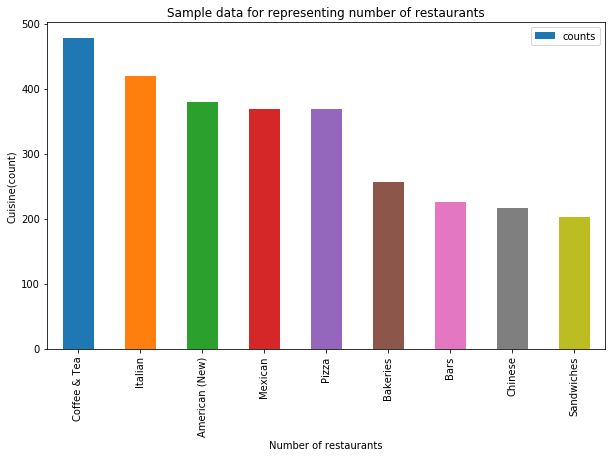

In [18]:
#Plot bar chart: # of restaurants by cuisine
popular_cuisines.plot(x="category",y="counts",kind="bar",figsize=(10,6))
plt.xlabel("Number of restaurants")
plt.ylabel("Cuisine(count)")
plt.title("Sample data for representing number of restaurants")

plt.show()

In [19]:
#Prepare dataframe for comparing # of reviews by price between San Francisco and New York
#Metropolitan/Urban cities
sanfrancisco = restaurant_df2.groupby('City').get_group('San Francisco')
newyork = restaurant_df2.groupby('City').get_group("New York")

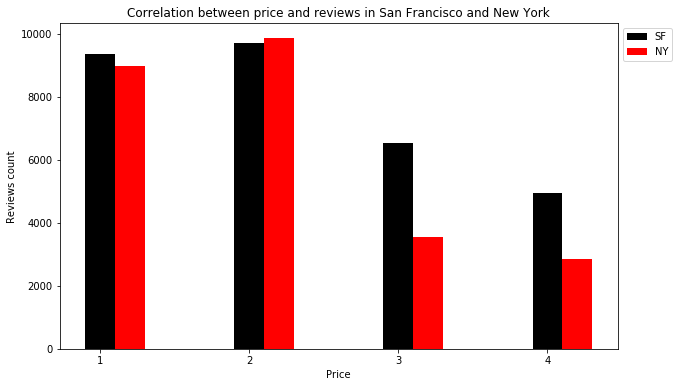

In [20]:
#Plot vertical bar chart: comparing # of reviews by price between San Francisco and New York
plt.figure(figsize=(10,6))
plt.bar(sanfrancisco["Price"],sanfrancisco["Reviews"],width=0.2,color='black',align='center',label="SF")
plt.bar((newyork["Price"]+0.2),newyork["Reviews"],width=0.2,color='r',align='center',label="NY")
plt.xlabel("Price")
plt.ylabel("Reviews count")
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.title("Correlation between price and reviews in San Francisco and New York")

#plt.figure(figsize=(10,6))
plt.xticks(np.arange(6),(0,1,2,3,4))
plt.plot()
plt.show()

In [24]:
#Prepare dataframe for comparing # of reviews by price between urban and rural states (CA+SF vs. NE+IA)
#Rural cities
urban = restaurant_df.loc[restaurant_df2["State"].isin(["CA","NY"])]
rural = restaurant_df.loc[restaurant_df2["State"].isin(["IA","NE"])]

In [26]:
#Prepare dataframe for illustrating cuisines by primary category
#Only retrieve categories where # of restaurants in each category > 160
urbancategories = urban["Category"].value_counts()
urbancategories_df = pd.DataFrame({'category':urbancategories.index, 'counts':urbancategories.values})
popular_urban_cuisines = urbancategories_df.loc[urbancategories_df["counts"]>160,["category","counts"]]

ValueError: 'explode' must be of length 'x'

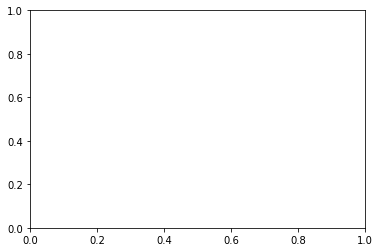

In [27]:

plt.pie(popular_urban_cuisines["counts"], labels=popular_urban_cuisines['category'],
         explode=(0,0.1,0,0.1,0),autopct='%1.f%%',radius=2,
         shadow=True, startangle=160)
plt.savefig("Top 5 type of restaurants in Urban areas")
plt.show()

In [ ]:
#Declare empty list to hold tweets by ID
#Declare word to search for and exclude retweets
tweet_list = []
word = 'RT @'

#Begin Twitter search
hashtag = ['#garydanko', "#misterjius", "#in-n-out"]

#Loop through each hashtag
for tag in hashtag:
    
    #Retrieve 500 most recent tweets
    hashtag_tweets = api.search(tag, rpp=100)
    
    #Loop through each tweet
    for tweet in hashtag_tweets["statuses"]:
        
        #Declare tweet_text = primary text of tweet
        tweet_text = tweet["text"]
        
        #Identify and exclude retweets
        if word in tweet['text']:
            continue
        else:
            tweet_list.append({"Hashtag": tag,
                               "Tweet": tweet_text})

len(tweet_list)

In [ ]:
# Create CSV file
with open('tweets.csv', 'w', newline='') as csvfile:
     fields = ['Hashtag', 'Tweet']
     writer = csv.DictWriter(csvfile, fieldnames=fields)
     writer.writeheader()
     for x in tweet_list:
         writer.writerow(x)

In [ ]:
f = pd.read_csv('tweets.csv', encoding='windows-1252')
f

In [ ]:
word = "hello world"
mystring = "hello worl"

if word not in mystring: 
    print('Word does not exist in string')
else:
    print('Word exists in string')